In [5]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time


import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications import VGG19
from keras.layers import AveragePooling2D,MaxPool2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
# The path of our data on drive
data_dir =  r'C:/Users/Meghana/Downloads/Project_work/COVID-19-Detection-From-X-Ray-master (2)/COVID-19-Detection-From-X-Ray-master/final_dataset'
 
# Loading Data
data = load_files(data_dir)

In [7]:
folders=os.listdir("C:/Users/Meghana/Downloads/Project_work/COVID-19-Detection-From-X-Ray-master (2)/COVID-19-Detection-From-X-Ray-master/final_dataset")
print(folders)

['COVID', 'non-COVID']


In [8]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  C:/Users/Meghana/Downloads/Project_work/COVID-19-Detection-From-X-Ray-master (2)/COVID-19-Detection-From-X-Ray-master/final_dataset\COVID\Covid (682).png
Target labels -  0
Number of training files :  2481
Number of training targets :  2481


In [9]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 224,224 
    #Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           224*224 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        
        #update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))

# The Data Shape
print(X.shape) 
print('First training item : ',X[0])

(2481, 224, 224, 3)
First training item :  [[[235. 235. 235.]
  [235. 235. 235.]
  [234. 234. 234.]
  ...
  [233. 233. 233.]
  [233. 233. 233.]
  [233. 233. 233.]]

 [[235. 235. 235.]
  [235. 235. 235.]
  [234. 234. 234.]
  ...
  [233. 233. 233.]
  [233. 233. 233.]
  [233. 233. 233.]]

 [[234. 234. 234.]
  [234. 234. 234.]
  [234. 234. 234.]
  ...
  [233. 233. 233.]
  [233. 233. 233.]
  [233. 233. 233.]]

 ...

 [[228. 228. 228.]
  [228. 228. 228.]
  [229. 229. 229.]
  ...
  [228. 228. 228.]
  [228. 228. 228.]
  [229. 229. 229.]]

 [[229. 229. 229.]
  [230. 230. 230.]
  [227. 227. 227.]
  ...
  [229. 229. 229.]
  [230. 230. 230.]
  [230. 230. 230.]]

 [[229. 229. 229.]
  [230. 230. 230.]
  [227. 227. 227.]
  ...
  [229. 229. 229.]
  [230. 230. 230.]
  [230. 230. 230.]]]


### Take a look at some pictures

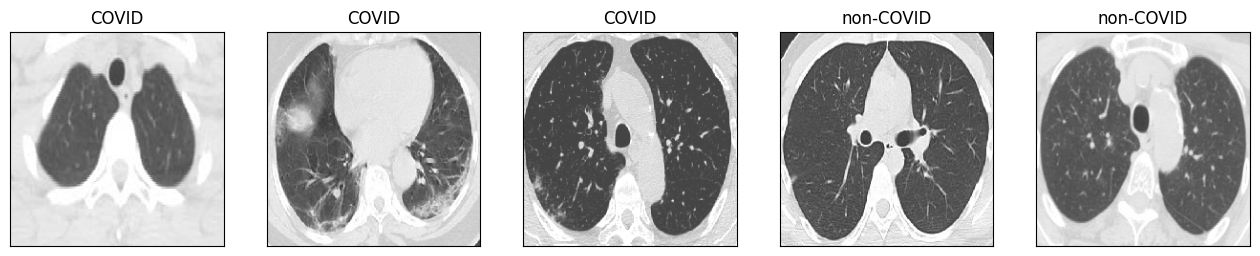

In [10]:
#Let's look at first 5 training data. 
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [11]:
"""
   After that data is converted into Numpy array, Now, 
   Let's scale the pixel intenties to the range[0,255]
"""
X = X.astype('float32')/255

# Let's confirm the number of classes :) 
no_of_classes = len(np.unique(y))
no_of_classes

2

In [12]:
y

array([0, 0, 0, ..., 0, 0, 1])

In [21]:
""" 
let's converts a class vector (integers) to binary class matrix by performing the 
one-hot encoding on the labels
"""
from tensorflow.keras.utils import to_categorical




y = np.array(to_categorical(y,no_of_classes))
y[0]

array([1., 0.])

In [22]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  1984
The validation Data Shape  249
The test Data Shape  248


In [23]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (224, 224, 3)


> **(224, 224, 3)** refers to the shape of the data (images) that will be fed into our CNN

---

In [29]:
VGG19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# setting the VGG model to be untrainable.
VGG19_model.trainable = False

In [30]:
VGG19_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [33]:
from keras.layers import BatchNormalization
Model = Sequential()
Model.add(VGG19_model)
Model.add(BatchNormalization())
Model.add(Dropout(0.20))
Model.add(Flatten())
Model.add(Dense(256,activation='relu'))
Model.add(Dense(2,activation='softmax'))


In [36]:
from keras.optimizers import Adam

# Corrected optimizer initialization
optimizer = Adam(learning_rate=1e-4)

# Assuming `Model` is your model instance
Model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


---

In [ ]:
from keras.callbacks import ModelCheckpoint


# Initialize the training data augmentation object
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Update the file path to end with .keras
checkpointer = ModelCheckpoint(filepath="/gdrive/My Drive/NouredAminaVGG19m.keras", save_best_only=True, verbose=1)

start = time.time()

# Train the model using the fit method with a generator
# Let's get started!
history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),
                            steps_per_epoch = len(X_train)//bs,
                            validation_data = (X_valid, y_valid),
                            validation_steps = len(X_valid)//bs,
                            epochs = epochs,
                            callbacks= [checkpointer])


end = time.time()
duration = end - start
print('\nThis Model took %0.2f seconds (%0.1f minutes) to train for %d epochs' % (duration, duration / 60, epochs))


In [40]:
(eval_loss, eval_accuracy) = Model.evaluate(  
     X_test, y_test, batch_size=bs, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

31/31 - 27s - 870ms/step - accuracy: 0.9839 - loss: 0.0557
Accuracy: 98.39%
Loss: 0.05573944374918938


### Accuracy and Loss graphs

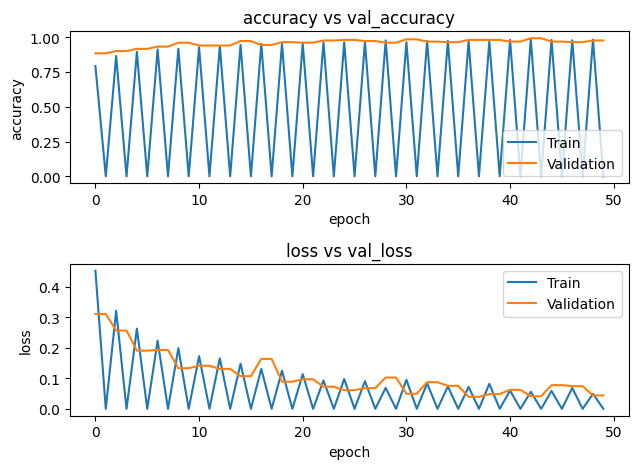

In [41]:
# Let's visualize the train/validation loss and accuracy wrt epochs

import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # summarize history for accuracy  
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
     # summarize history for loss  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
# Finaly, let's call the plot function with the 'result' parameter 
 
plot(history)

8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step


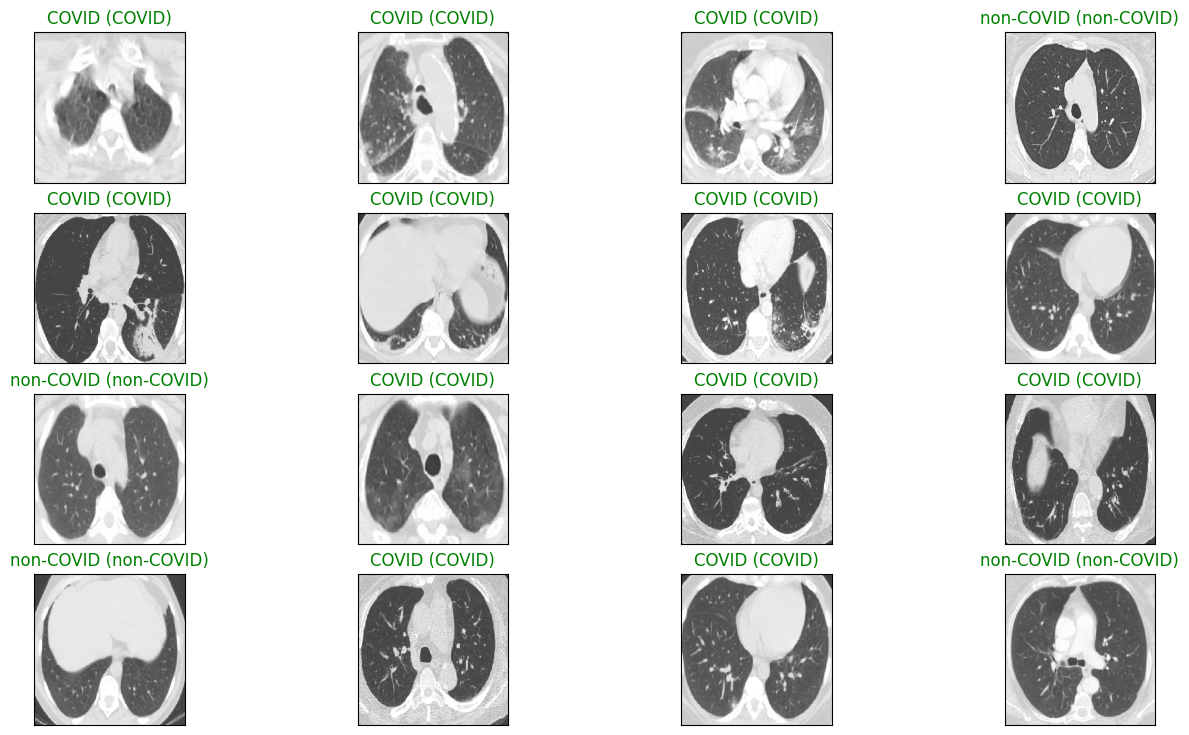

In [42]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(Model.predict(X_test))

### Confusion Matrix
> Please note that, **_0_ and _1_ values represent _Covid-19_ and _No_findigs_ respectively**  .

8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step


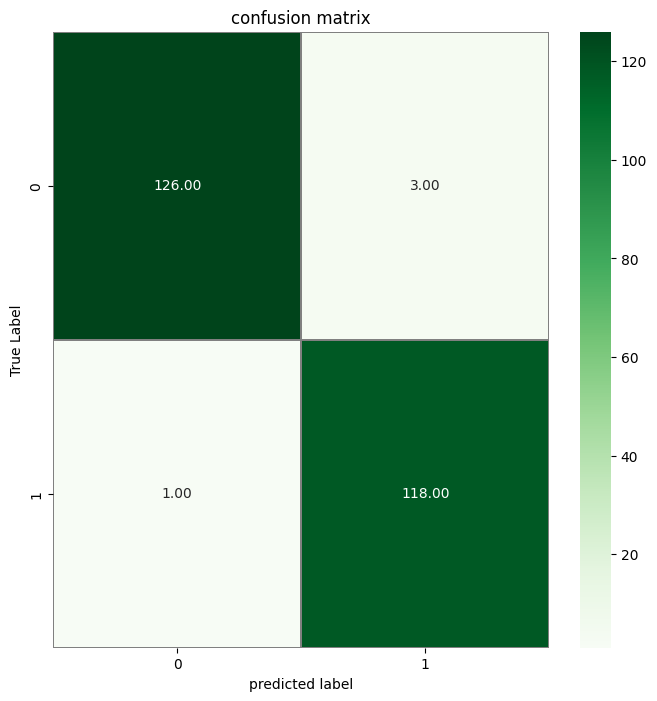

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = Model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [44]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

       COVID       0.99      0.98      0.98       129
   non-COVID       0.98      0.99      0.98       119

    accuracy                           0.98       248
   macro avg       0.98      0.98      0.98       248
weighted avg       0.98      0.98      0.98       248



### Loading the model
> Here we're gonna load our best model trained befor, then make some predictions with it !

8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step


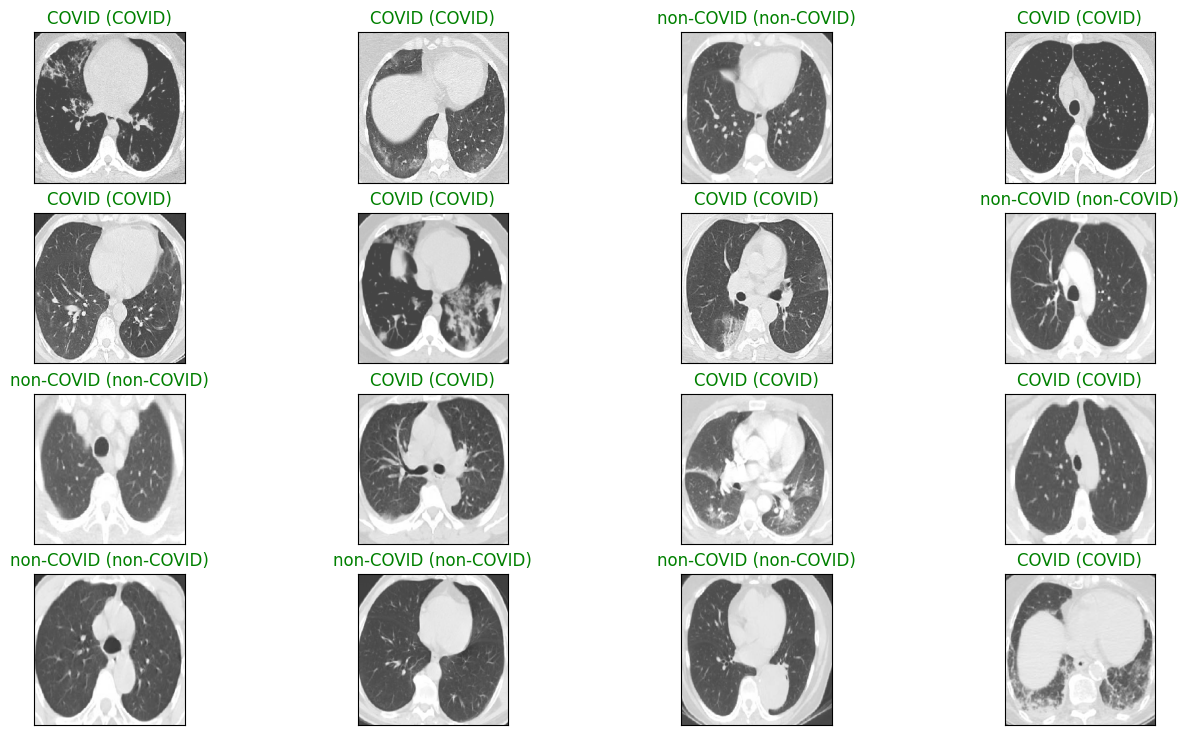

In [47]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(Model.predict(X_test))